In [1]:
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt

import neurobayes as nb
from neurobayes.flax_nets import FlaxMLP

Define imaginary theoretical and experimental data:

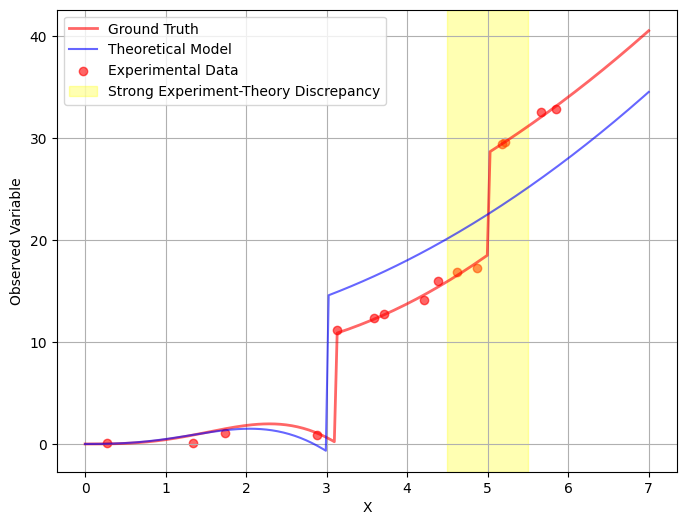

In [2]:
# Theoretical model with a single discontinuous transition
def theory_func(x):
    return np.where(x < 3, np.sin(x+0.3) * 0.5 * x**2, 0.5 * x**2 + 10)

# Experimental model with two discontinuous transitions
def experiment_func(x):
    return np.piecewise(
        x,
        [x < 3.1, (x >= 3.1) & (x < 5), x >= 5],
        [
            lambda x: np.sin(x) * 0.5 * x**2,         
            lambda x: np.sin(0.2*x) * 0.5 * x**2 + 8,
            lambda x: 0.5 * x**2 + 16 
        ]
    )


np.random.seed(333)  # for reproducibility

# Theoretical model data
X1 = np.linspace(0, 7, 200)
y1 = theory_func(X1) + np.random.normal(0, 0.0, X1.shape)

# Experimental data
X2 = np.random.uniform(0, 7, 15)
y2 = experiment_func(X2) + np.random.normal(0, 0.5, X2.shape)

# Ground truth for each fidelity
X_full_range = np.linspace(0, 7, 200)
y1_true = theory_func(X_full_range)  # same as y1 in the absence of noise for theoretical data
y2_true = experiment_func(X_full_range)


# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(X_full_range, y2_true, 'r-', label='Ground Truth', alpha=0.6, linewidth=2)
plt.plot(X1, y1, 'b-', label='Theoretical Model', alpha=0.6)
plt.scatter(X2, y2, c='r', label='Experimental Data', alpha=0.6)
plt.axvspan(4.5, 5.5, color='yellow', alpha=0.3, label='Strong Experiment-Theory Discrepancy')
plt.xlabel('X')
plt.ylabel('Observed Variable')
plt.legend()
plt.grid(True)
plt.legend()
plt.show()

Normalize X values (if needed):

In [3]:
xmax = X_full_range.max()

X1 = X1 / xmax
X2 = X2 / xmax
X_full_range = X_full_range / xmax

Fit deterministic NN to theoretical data. Strictly speaking, we should do a proper train-test-validation split, but here we skip it.

In [4]:
hidden_dims = [64, 32, 16, 8]

net = FlaxMLP(hidden_dims, target_dim=1)
detnn = nb.DeterministicNN(net, input_shape=(1,), learning_rate=5e-3, map=True, sigma=nb.utils.calculate_sigma(X1))
detnn.train(X1, y1, epochs=5000, batch_size=None)

Training Progress: 100%|██████████| 5000/5000 [00:03<00:00, 1429.11it/s, Epoch 5000/5000, Avg Loss: 1.8306]


Text(0, 0.5, '$y$')

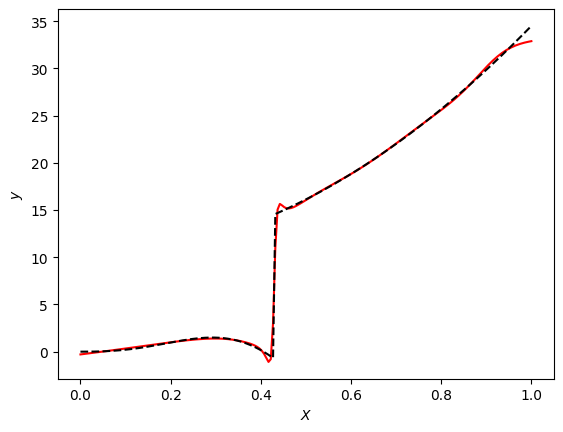

In [5]:
y_pred = detnn.predict(X_full_range)
plt.plot(X_full_range, y_pred, c='r')
plt.plot(X_full_range, y1_true, '--', c='k')
plt.xlabel("$X$")
plt.ylabel("$y$")

Now let's train a BNN on experimental data but use the weights pre-trained on theoretical data to set BNN priors:

In [6]:
model = nb.BNN(target_dim=1, hidden_dim=hidden_dims)
model.fit(
    X2, y2, num_warmup=1000, num_samples=1000, num_chains=1,
    pretrained_priors=detnn.state.params  # use trained weights to set priors for BNN
)

sample: 100%|██████████| 2000/2000 [01:24<00:00, 23.66it/s, 1023 steps of size 1.27e-03. acc. prob=0.90]


Make a prediction for the entire data range and plot it:

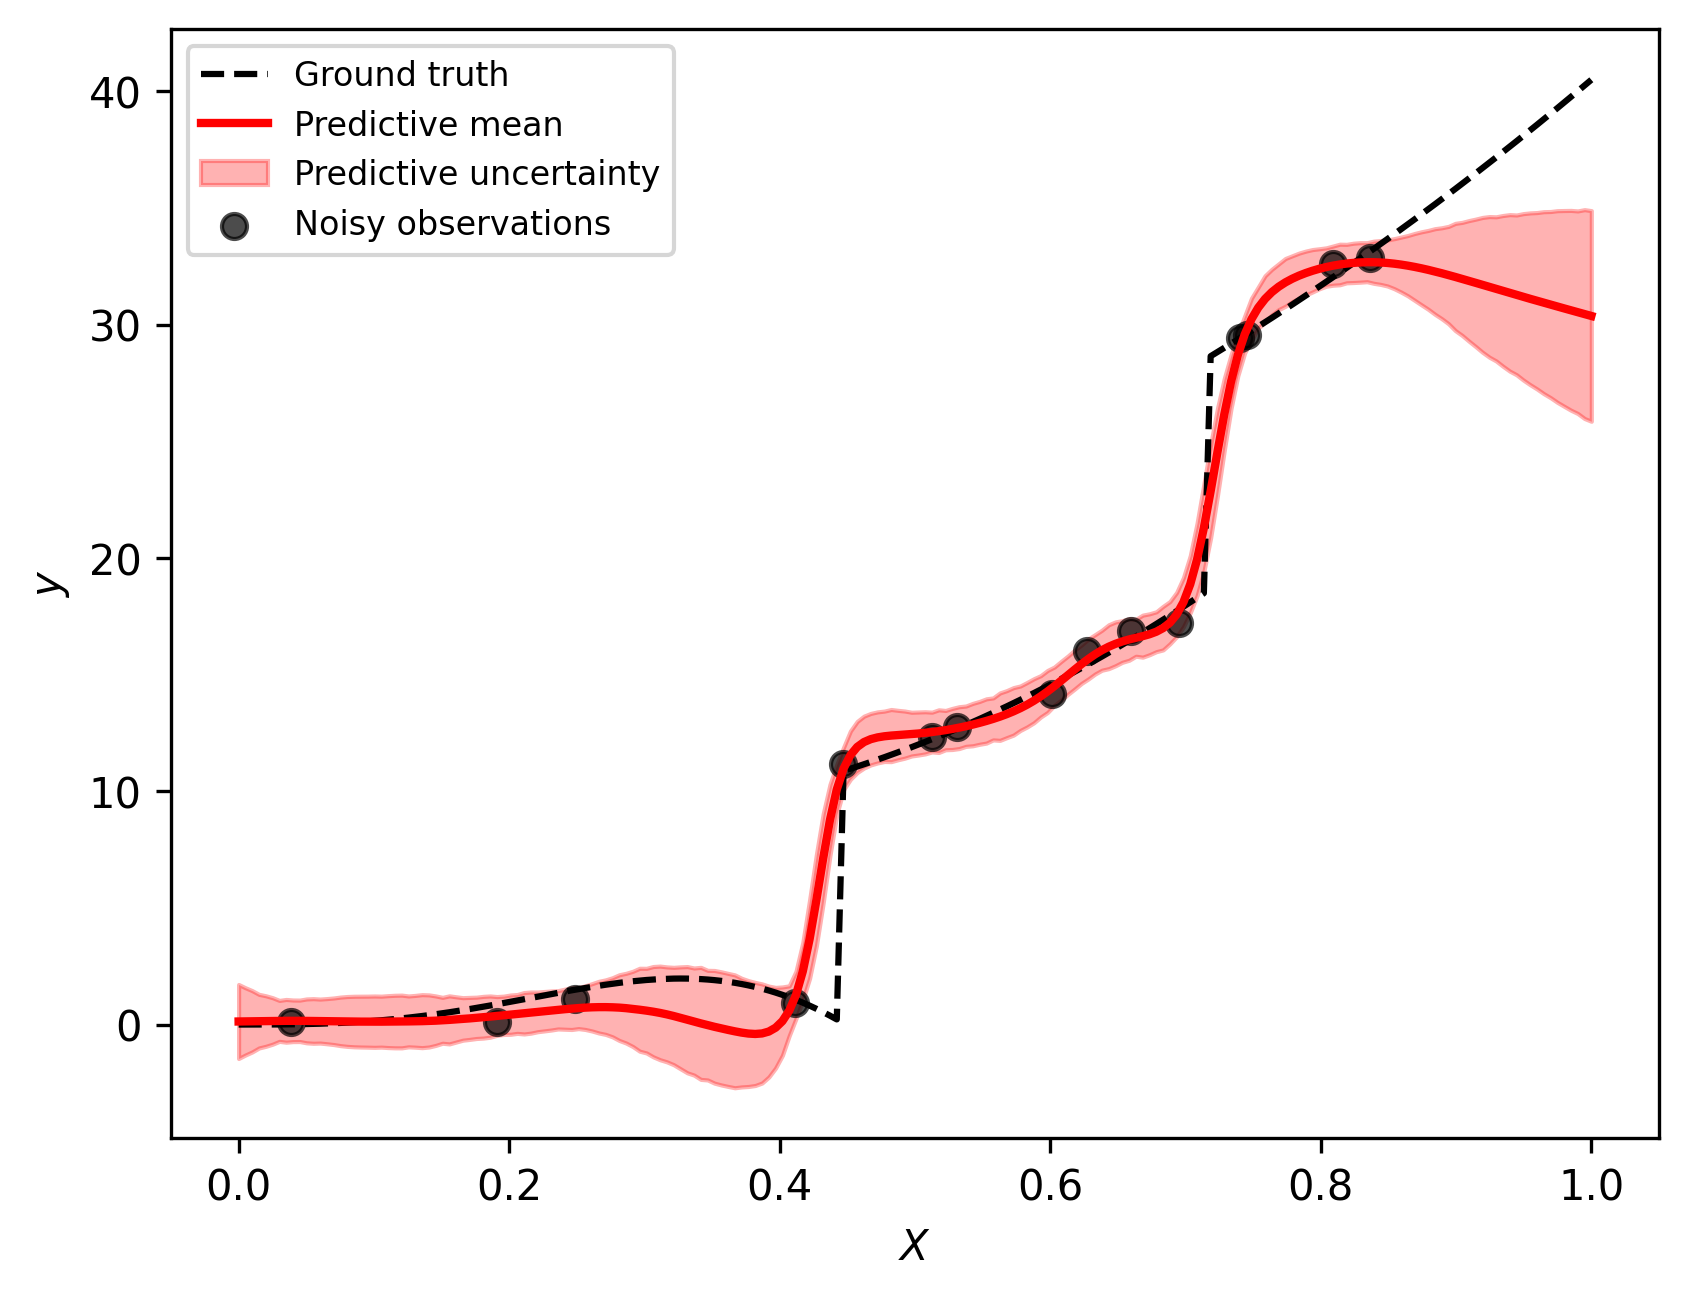

In [7]:
posterior_mean, posterior_var = model.predict(X_full_range)

posterior_mean = posterior_mean.squeeze()
posterior_var = posterior_var.squeeze()

_, ax = plt.subplots(dpi=300)
ax.set_xlabel("$X$")
ax.set_ylabel("$y$")
ax.plot(X_full_range, y2_true, '--', c='k', label='Ground truth')
ax.plot(X_full_range, posterior_mean, lw=2.0,  c='r', label='Predictive mean')
ax.fill_between(X_full_range,
                posterior_mean - np.sqrt(posterior_var),
                posterior_mean + np.sqrt(posterior_var),
                color='r', alpha=0.3, label="Predictive uncertainty")

ax.scatter(X2, y2, label="Noisy observations", c='k', alpha=0.7)
ax.legend(loc='best', fontsize=8)
plt.show()


In [8]:
mse1 = nb.utils.mse(posterior_mean, y2_true)
nlpd1 = nb.utils.nlpd(y2_true, posterior_mean, posterior_var)

Now repeat it without pre-trained priors to see the difference:

In [9]:
model = nb.BNN(target_dim=1, hidden_dim=hidden_dims)
model.fit(
    X2, y2, num_warmup=1000, num_samples=1000, num_chains=1,
    pretrained_priors=None  # priors are zero centered normal distributions
)

sample: 100%|██████████| 2000/2000 [00:42<00:00, 46.68it/s, 511 steps of size 1.14e-02. acc. prob=0.85]


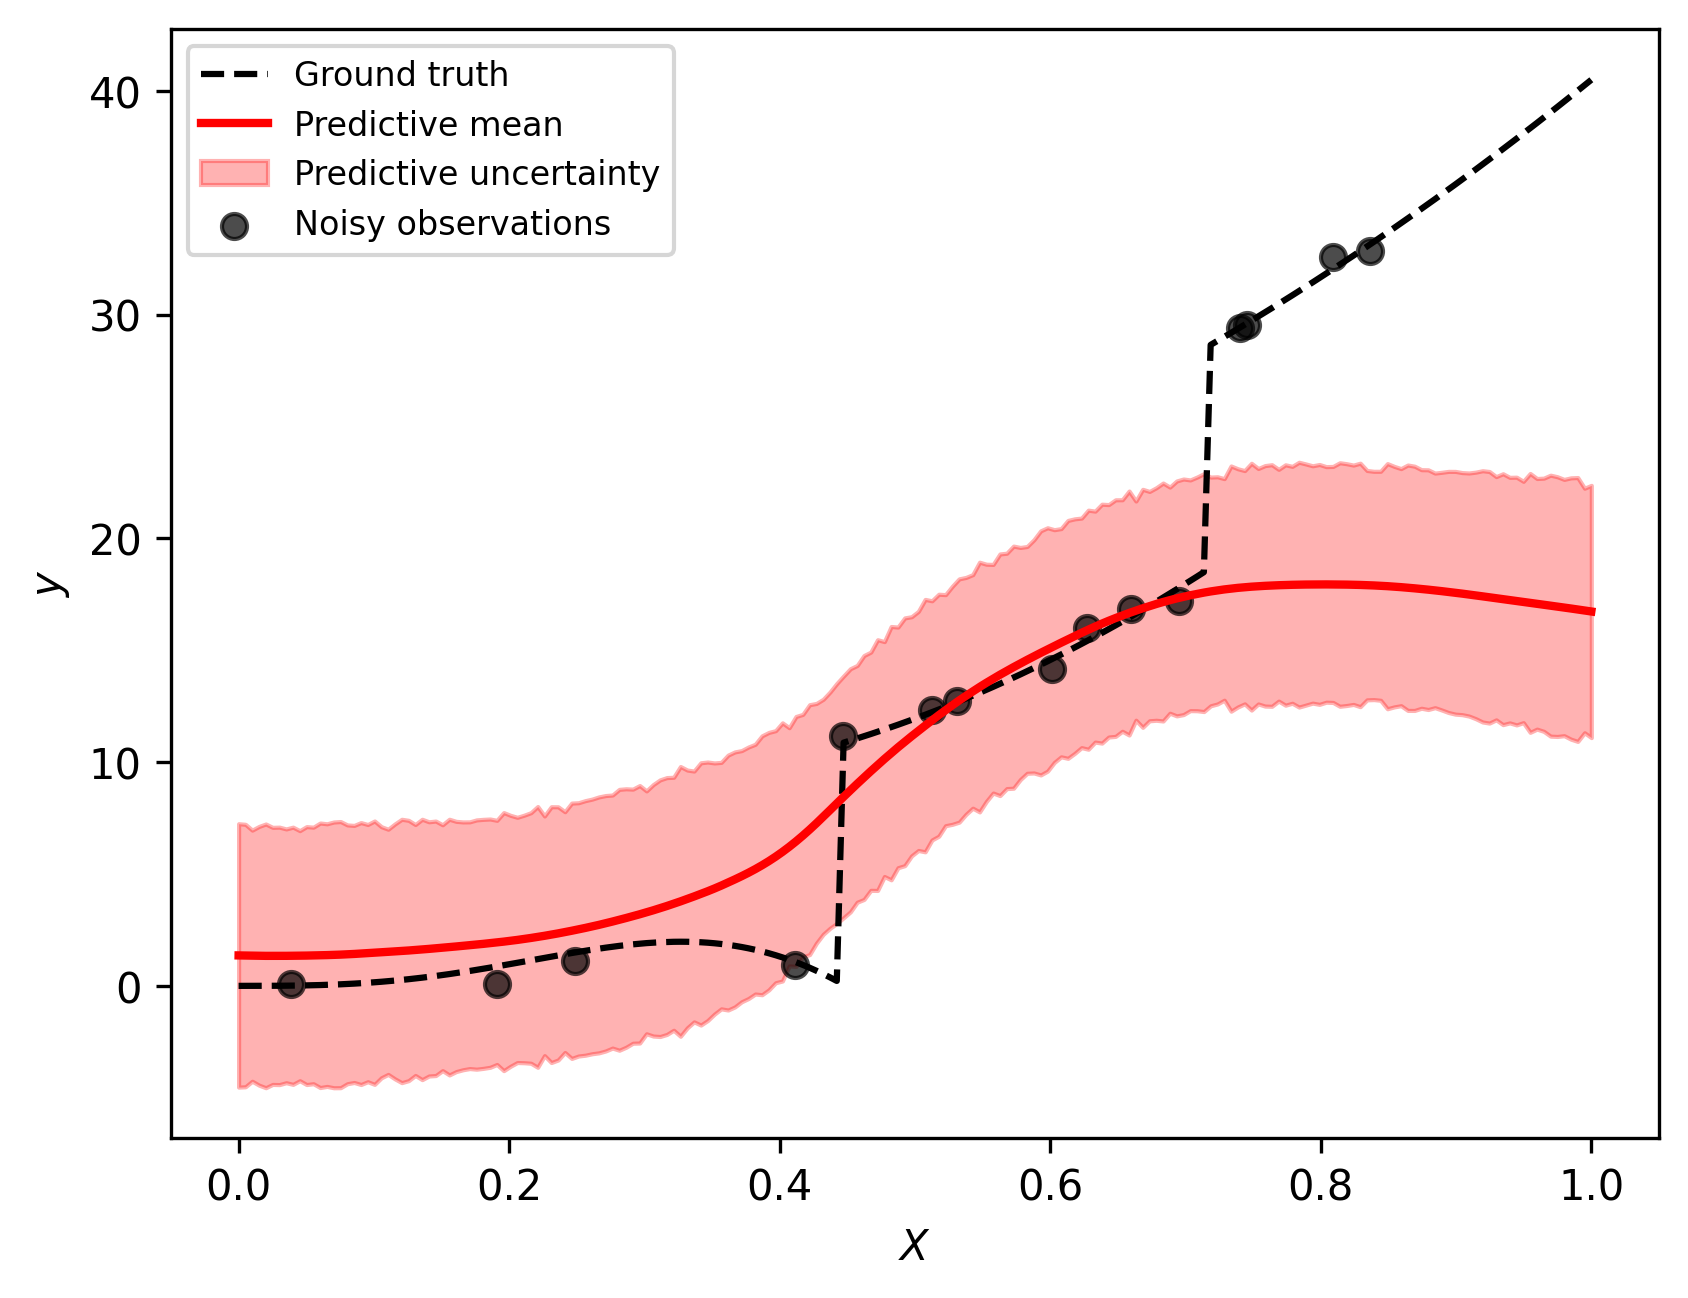

In [10]:
posterior_mean, posterior_var = model.predict(X_full_range)

posterior_mean = posterior_mean.squeeze()
posterior_var = posterior_var.squeeze()

_, ax = plt.subplots(dpi=300)
ax.set_xlabel("$X$")
ax.set_ylabel("$y$")
ax.plot(X_full_range, y2_true, '--', c='k', label='Ground truth')
ax.plot(X_full_range, posterior_mean, lw=2.0,  c='r', label='Predictive mean')
ax.fill_between(X_full_range,
                posterior_mean - np.sqrt(posterior_var),
                posterior_mean + np.sqrt(posterior_var),
                color='r', alpha=0.3, label="Predictive uncertainty")

ax.scatter(X2, y2, label="Noisy observations", c='k', alpha=0.7)
ax.legend(loc='best', fontsize=8)
plt.show()


In [11]:
mse2 = nb.utils.mse(posterior_mean, y2_true)
nlpd2 = nb.utils.nlpd(y2_true, posterior_mean, posterior_var)

Compare results:

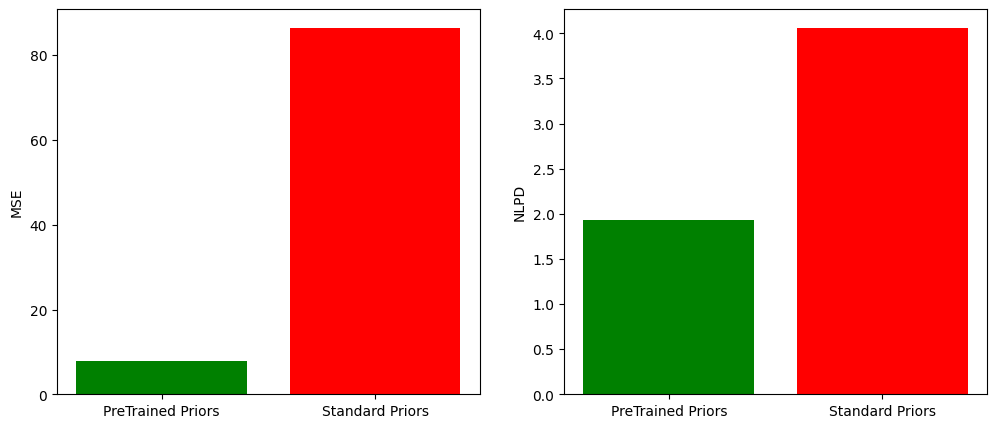

In [12]:
# Labels for the bars
labels = ["PreTrained Priors", "Standard Priors"]
# MSE and NLPD values
mse_values = [mse1, mse2]
nlpd_values = [nlpd1, nlpd2]
# Colors for each model
colors = ['green', 'red']
# Plot
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.bar(labels, mse_values, color=colors)
ax1.set_ylabel("MSE")
ax2.bar(labels, nlpd_values, color=colors)
ax2.set_ylabel("NLPD")
plt.show()

Compare to regular GP:

In [13]:
model = nb.GP(kernel=nb.kernels.MaternKernel)
model.fit(X2, y2, num_warmup=1000, num_samples=1000, num_chains=1)

sample: 100%|██████████| 2000/2000 [00:01<00:00, 1982.46it/s, 7 steps of size 3.91e-01. acc. prob=0.94]


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.12      0.03      0.11      0.07      0.16    224.09      1.03
    k_scale    113.35     44.56    103.94     52.38    181.72    615.36      1.00
      noise      1.24      0.75      1.14      0.10      2.33    443.90      1.02



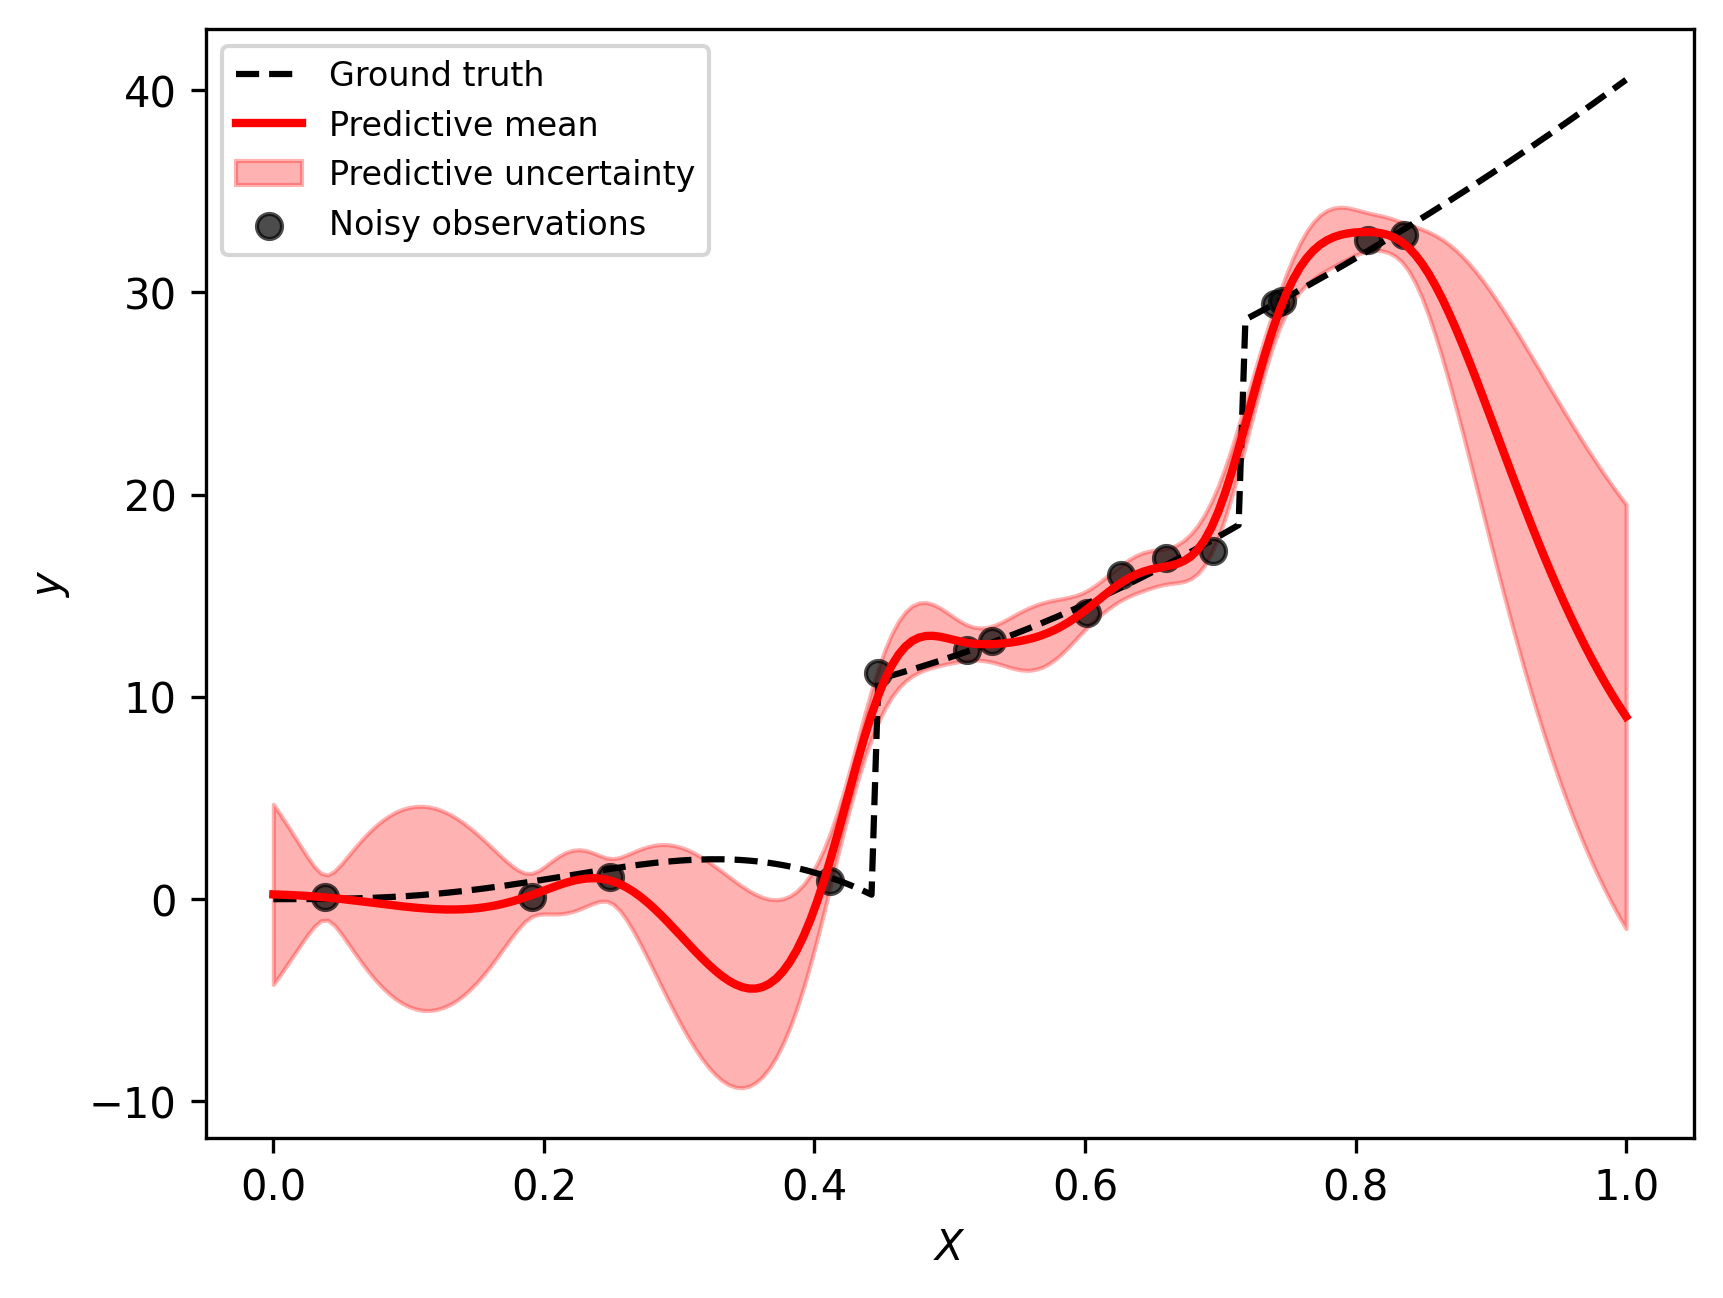

In [14]:
posterior_mean, posterior_var = model.predict(X_full_range)

posterior_mean = posterior_mean.squeeze()
posterior_var = posterior_var.squeeze()

_, ax = plt.subplots(dpi=300)
ax.set_xlabel("$X$")
ax.set_ylabel("$y$")
ax.plot(X_full_range, y2_true, '--', c='k', label='Ground truth')
ax.plot(X_full_range, posterior_mean, lw=2.0,  c='r', label='Predictive mean')
ax.fill_between(X_full_range,
                posterior_mean - np.sqrt(posterior_var),
                posterior_mean + np.sqrt(posterior_var),
                color='r', alpha=0.3, label="Predictive uncertainty")

ax.scatter(X2, y2, label="Noisy observations", c='k', alpha=0.7)
ax.legend(loc='best', fontsize=8)
plt.show()


In [15]:
mse3 = nb.utils.mse(posterior_mean, y2_true)
nlpd3 = nb.utils.nlpd(y2_true, posterior_mean, posterior_var)

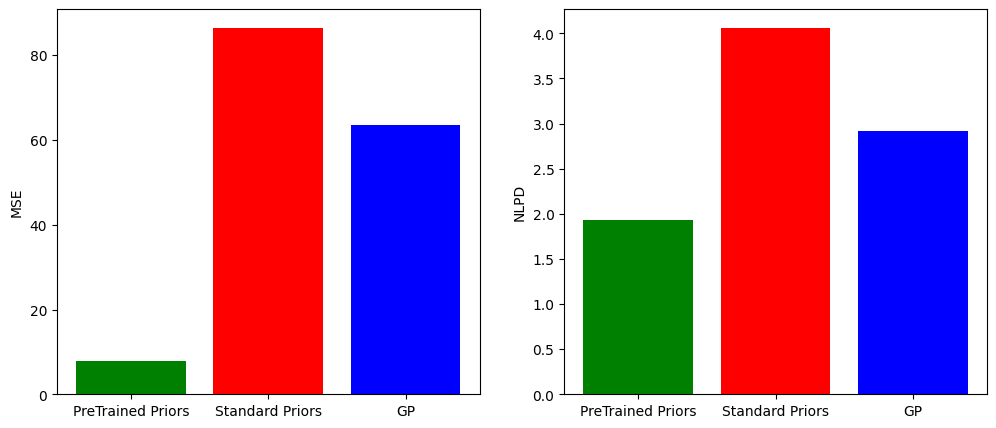

In [16]:
# Labels for the bars
labels = ["PreTrained Priors", "Standard Priors", "GP"]
# MSE and NLPD values
mse_values = [mse1, mse2, mse3]
nlpd_values = [nlpd1, nlpd2, nlpd3]
# Colors for each model
colors = ['green', 'red', 'blue']
# Plot
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.bar(labels, mse_values, color=colors)
ax1.set_ylabel("MSE")
ax2.bar(labels, nlpd_values, color=colors)
ax2.set_ylabel("NLPD")
plt.show()